# PROBLEM STATEMENT

- This notebook implements a movie recommender system. 
- Recommender systems are used to suggest movies or songs to users based on their interest or usage history. 
- For example, Netflix recommends movies to watch based on the previous movies you've watched.  
- In this example, we will use Item-based Collaborative Filter 



- Dataset MovieLens: https://grouplens.org/datasets/movielens/100k/ 
- Photo Credit: https://pxhere.com/en/photo/1588369

# STEP #0: LIBRARIES IMPORT


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# STEP #1: IMPORT DATASET

In [2]:
# Two datasets are available, let's load the first one:
movie_titles_df = pd.read_csv("Movie_Id_Titles")
movie_titles_df.head(20)

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
6,7,Twelve Monkeys (1995)
7,8,Babe (1995)
8,9,Dead Man Walking (1995)
9,10,Richard III (1995)


In [3]:
# Let's load the second one!
movies_rating_df = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

In [4]:
movies_rating_df.head(10)

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742
5,22,377,1,878887116
6,244,51,2,880606923
7,166,346,1,886397596
8,298,474,4,884182806
9,115,265,2,881171488


In [5]:
movies_rating_df.tail()

,user_id,item_id,rating,timestamp
99998,880,476,3,880175444
99999,716,204,5,879795543
100000,276,1090,1,874795795
100001,13,225,2,882399156
100002,12,203,3,879959583


In [6]:
# Let's drop the timestamp 
movies_rating_df.drop(['timestamp'], axis = 1, inplace = True)

In [7]:
movies_rating_df

,user_id,item_id,rating
0,0,50,5
1,0,172,5
2,0,133,1
3,196,242,3
4,186,302,3
...,...,...,...
99998,880,476,3
99999,716,204,5
100000,276,1090,1
100001,13,225,2


In [8]:
movies_rating_df.describe()

,user_id,item_id,rating
count,100003.000000,100003.000000,100003.000000
mean,462.470876,425.520914,3.529864
std,266.622454,330.797791,1.125704
min,0.000000,1.000000,1.000000
25%,254.000000,175.000000,3.000000
50%,447.000000,322.000000,4.000000
75%,682.000000,631.000000,4.000000
max,943.000000,1682.000000,5.000000


In [9]:
movies_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100003 entries, 0 to 100002
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   user_id  100003 non-null  int64
 1   item_id  100003 non-null  int64
 2   rating   100003 non-null  int64
dtypes: int64(3)
memory usage: 2.3 MB


In [10]:
# Let's merge both dataframes together so we can have ID with the movie name
movies_rating_df = pd.merge(movies_rating_df, movie_titles_df, on = 'item_id') 

In [11]:
movies_rating_df

,user_id,item_id,rating,title
0,0,50,5,Star Wars (1977)
1,290,50,5,Star Wars (1977)
2,79,50,4,Star Wars (1977)
3,2,50,5,Star Wars (1977)
4,8,50,5,Star Wars (1977)
...,...,...,...,...
99998,840,1674,4,Mamma Roma (1962)
99999,655,1640,3,"Eighth Day, The (1996)"
100000,655,1637,3,Girls Town (1996)
100001,655,1630,3,"Silence of the Palace, The (Saimt el Qusur) (1..."


In [12]:
movies_rating_df.shape

(100003, 4)

# STEP #2: VISUALIZE DATASET

In [13]:
movies_rating_df.groupby('title')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
title,,,,,,,,
'Til There Was You (1997),9.0,2.333333,1.000000,1.0,2.00,2.0,3.0,4.0
1-900 (1994),5.0,2.600000,1.516575,1.0,1.00,3.0,4.0,4.0
101 Dalmatians (1996),109.0,2.908257,1.076184,1.0,2.00,3.0,4.0,5.0
12 Angry Men (1957),125.0,4.344000,0.719588,2.0,4.00,4.0,5.0,5.0
187 (1997),41.0,3.024390,1.172344,1.0,2.00,3.0,4.0,5.0
...,...,...,...,...,...,...,...,...
Young Guns II (1990),44.0,2.772727,1.008421,1.0,2.00,3.0,3.0,5.0
"Young Poisoner's Handbook, The (1995)",41.0,3.341463,1.237129,1.0,3.00,4.0,4.0,5.0
Zeus and Roxanne (1997),6.0,2.166667,0.983192,1.0,1.25,2.5,3.0,3.0


In [14]:
ratings_df_mean = movies_rating_df.groupby('title')['rating'].describe()['mean']

In [15]:
ratings_df_count = movies_rating_df.groupby('title')['rating'].describe()['count']

In [16]:
ratings_df_count

title
'Til There Was You (1997)                  9.0
1-900 (1994)                               5.0
101 Dalmatians (1996)                    109.0
12 Angry Men (1957)                      125.0
187 (1997)                                41.0
                                         ...  
Young Guns II (1990)                      44.0
Young Poisoner's Handbook, The (1995)     41.0
Zeus and Roxanne (1997)                    6.0
unknown                                    9.0
Á köldum klaka (Cold Fever) (1994)         1.0
Name: count, Length: 1664, dtype: float64

In [17]:
ratings_mean_count_df = pd.concat([ratings_df_count, ratings_df_mean], axis = 1)

In [18]:
ratings_mean_count_df.reset_index()

,title,count,mean
0,'Til There Was You (1997),9.0,2.333333
1,1-900 (1994),5.0,2.600000
2,101 Dalmatians (1996),109.0,2.908257
3,12 Angry Men (1957),125.0,4.344000
4,187 (1997),41.0,3.024390
...,...,...,...
1659,Young Guns II (1990),44.0,2.772727
1660,"Young Poisoner's Handbook, The (1995)",41.0,3.341463
1661,Zeus and Roxanne (1997),6.0,2.166667
1662,unknown,9.0,3.444444


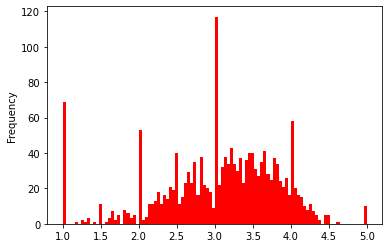

In [19]:
ratings_mean_count_df['mean'].plot(bins=100, kind='hist', color = 'r') 

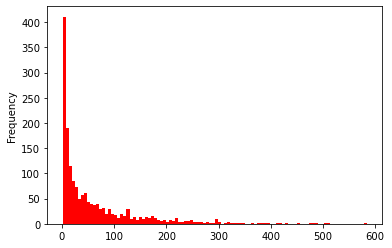

In [20]:
ratings_mean_count_df['count'].plot(bins=100, kind='hist', color = 'r') 

In [21]:
# Let's see the highest rated movies!
# Apparently these movies does not have many reviews (i.e.: small number of ratings)
ratings_mean_count_df[ratings_mean_count_df['mean'] == 5]

,count,mean
title,,
Aiqing wansui (1994),1.0,5.0
Entertaining Angels: The Dorothy Day Story (1996),1.0,5.0
"Great Day in Harlem, A (1994)",1.0,5.0
Marlene Dietrich: Shadow and Light (1996),1.0,5.0
Prefontaine (1997),3.0,5.0
"Saint of Fort Washington, The (1993)",2.0,5.0
Santa with Muscles (1996),2.0,5.0
Someone Else's America (1995),1.0,5.0
Star Kid (1997),3.0,5.0


In [22]:
# List all the movies that are most rated
# Please note that they are not necessarily have the highest rating (mean)
ratings_mean_count_df.sort_values('count', ascending = False).head(100)

,count,mean
title,,
Star Wars (1977),584.0,4.359589
Contact (1997),509.0,3.803536
Fargo (1996),508.0,4.155512
Return of the Jedi (1983),507.0,4.007890
Liar Liar (1997),485.0,3.156701
...,...,...
Aladdin (1992),219.0,3.812785
Babe (1995),219.0,3.995434
Volcano (1997),219.0,2.808219


# STEP #3: PERFORM ITEM-BASED COLLABORATIVE FILTERING ON ONE MOVIE SAMPLE

In [23]:
userid_movietitle_matrix = movies_rating_df.pivot_table(index = 'user_id', columns = 'title', values = 'rating')


In [24]:
userid_movietitle_matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
titanic = userid_movietitle_matrix['Titanic (1997)']


In [26]:
titanic

user_id
0      NaN
1      NaN
2      5.0
3      NaN
4      NaN
      ... 
939    NaN
940    5.0
941    NaN
942    3.0
943    NaN
Name: Titanic (1997), Length: 944, dtype: float64

In [27]:
# Let's calculate the correlations
titanic_correlations = pd.DataFrame(userid_movietitle_matrix.corrwith(titanic), columns=['Correlation'])
titanic_correlations = titanic_correlations.join(ratings_mean_count_df['count'])


/Users/ankurmohanty/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/ankurmohanty/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [28]:
titanic_correlations

,Correlation,count
title,,
'Til There Was You (1997),-0.062017,9.0
1-900 (1994),NaN,5.0
101 Dalmatians (1996),0.120113,109.0
12 Angry Men (1957),0.077700,125.0
187 (1997),0.315654,41.0
...,...,...
Young Guns II (1990),0.317274,44.0
"Young Poisoner's Handbook, The (1995)",0.356783,41.0
Zeus and Roxanne (1997),NaN,6.0


In [29]:
titanic_correlations.dropna(inplace=True)
titanic_correlations

,Correlation,count
title,,
'Til There Was You (1997),-0.062017,9.0
101 Dalmatians (1996),0.120113,109.0
12 Angry Men (1957),0.077700,125.0
187 (1997),0.315654,41.0
2 Days in the Valley (1996),0.017295,93.0
...,...,...
Year of the Horse (1997),1.000000,7.0
Young Frankenstein (1974),0.107666,200.0
Young Guns (1988),0.199931,101.0


In [30]:
# Let's sort the correlations vector
titanic_correlations.sort_values('Correlation', ascending=False)

,Correlation,count
title,,
Nadja (1994),1.0,8.0
"Pest, The (1997)",1.0,8.0
"Savage Nights (Nuits fauves, Les) (1992)",1.0,3.0
For Ever Mozart (1996),1.0,3.0
"Jerky Boys, The (1994)",1.0,3.0
...,...,...
Pather Panchali (1955),-1.0,8.0
Angel Baby (1995),-1.0,4.0
Blood Beach (1981),-1.0,6.0


In [31]:
titanic_correlations[titanic_correlations['count']>80].sort_values('Correlation',ascending=False).head()

,Correlation,count
title,,
Titanic (1997),1.000000,350.0
"River Wild, The (1994)",0.497600,146.0
"Abyss, The (1989)",0.472103,151.0
Bram Stoker's Dracula (1992),0.443560,120.0
True Lies (1994),0.435104,208.0


In [32]:
# Pick up star wars movie and repeat the excerise

# STEP#4: CREATE AN ITEM-BASED COLLABORATIVE FILTER ON THE ENTIRE DATASET 

In [33]:
# Recall this matrix that we created earlier of all movies and their user ID/ratings
userid_movietitle_matrix

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
movie_correlations = userid_movietitle_matrix.corr(method = 'pearson', min_periods = 80)
# pearson : standard correlation coefficient
# Obtain the correlations between all movies in the dataframe

In [35]:
movie_correlations

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
title,,,,,,,,,,,,,,,,,,,,,
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1-900 (1994),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.178848,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
187 (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Young Guns II (1990),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Young Poisoner's Handbook, The (1995)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Zeus and Roxanne (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Let's create our own dataframe with our own ratings!
myRatings = pd.read_csv("My_Ratings.csv")
#myRatings.reset_index

In [37]:
myRatings

,Movie Name,Ratings
0,Liar Liar (1997),5
1,Star Wars (1977),1


In [38]:
len(myRatings.index)

2

In [39]:
myRatings['Movie Name'][0]

'Liar Liar (1997)'

In [40]:
similar_movies_list = pd.Series()
for i in range(0, 2):
    similar_movie = movie_correlations[myRatings['Movie Name'][i]].dropna() # Get same movies with same ratings
    similar_movie = similar_movie.map(lambda x: x * myRatings['Ratings'][i]) # Scale the similarity by your given ratings
    similar_movies_list = similar_movies_list.append(similar_movie)


<ipython-input-40-3cffc3c9d39a>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  similar_movies_list = pd.Series()


In [41]:
similar_movies_list.sort_values(inplace = True, ascending = False)
print (similar_movies_list.head(10))

Liar Liar (1997)                             5.000000
Con Air (1997)                               2.349141
Pretty Woman (1990)                          2.348951
Michael (1996)                               2.210110
Indiana Jones and the Last Crusade (1989)    2.072136
Top Gun (1986)                               2.028602
G.I. Jane (1997)                             1.989656
Multiplicity (1996)                          1.984302
Grumpier Old Men (1995)                      1.953494
Ghost and the Darkness, The (1996)           1.895376
dtype: float64
